In [458]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

pwd = 'work'

Part 2: Predictive Modelling

Objective: To build a simple predictive model using one feature engineered in the previous
task plus the market average price. Build this baseline model first and if time permits and
you can explore more complex models with more features incorporated.

Task:

You are required to use two features from the provided dataset and market data to build
your pricing model.

* Create a model to recommend price per night for the next 12 months for the
test property.

* I would recommend using the Booking lead time and Competitor
average price as 2 of the features for this test.

In [459]:
# Load the data from the cleaned CSV file
pricing_data = pd.read_csv(pwd + '/data/pricing_data_cleaned.csv')
booking_data = pd.read_csv(pwd + '/data/booking_data_cleaned.csv')
competitor_data = pd.read_csv(pwd + '/data/competitor_data_cleaned.csv')

# Check head of the data
print(pricing_data.head())
print(booking_data.head())
print(competitor_data.head())


  Accommodation name  Property ID        Date  Day  \
0        Test home 1       123456  2022-01-01    5   
1        Test home 1       123456  2022-01-02    6   
2        Test home 1       123456  2022-01-03    0   
3        Test home 1       123456  2022-01-04    1   
4        Test home 1       123456  2022-01-05    2   

   Price per night without tax  Year  Month Day of the Week  Weekend  
0                        171.0  2022      1        Saturday     True  
1                        107.0  2022      1          Sunday     True  
2                         68.0  2022      1          Monday    False  
3                         64.0  2022      1         Tuesday    False  
4                         64.0  2022      1       Wednesday    False  
  Booking number Booking Date     Status Check-in date Check-out date  nights  \
0          TEST1   2024-08-15       Paid    2024-12-05     2024-12-10     5.0   
1          TEST2   2024-08-07  Confirmed    2024-08-07     2024-08-08     1.0   
2     

In [460]:
# Check the data types of the columns
print(pricing_data.dtypes)
print(booking_data.dtypes)
print(competitor_data.dtypes)

Accommodation name              object
Property ID                      int64
Date                            object
Day                              int64
Price per night without tax    float64
Year                             int64
Month                            int64
Day of the Week                 object
Weekend                           bool
dtype: object
Booking number                  object
Booking Date                    object
Status                          object
Check-in date                   object
Check-out date                  object
nights                         float64
Price per night without tax    float64
Rent with VAT on top           float64
Rent without VAT               float64
Extras with VAT on top         float64
Extras without VAT             float64
Booking total with tax         float64
Booking total without tax      float64
Total tax                      float64
Paid                           float64
Adults                           int64
Children   

In [461]:
# Convert types to the correct format
pricing_data['Date'] = pd.to_datetime(pricing_data['Date'])
pricing_data['Day'] = pricing_data['Date'].dt.day_of_week
pricing_data['Year'] = pricing_data['Year'].astype(int)
pricing_data['Property ID'] = pricing_data['Property ID'].astype(int)
pricing_data['Accommodation name'] = pricing_data['Accommodation name'].astype(str)

booking_data['Booking Date'] = pd.to_datetime(booking_data['Booking Date'])
booking_data['Day'] = booking_data['Booking Date'].dt.day_of_week
booking_data['Year'] = booking_data['Booking Date'].dt.year
booking_data['Property ID'] = booking_data['Property ID'].astype(int)
booking_data['Check-in date'] = pd.to_datetime(booking_data['Check-in date'])
booking_data['Check-out date'] = pd.to_datetime(booking_data['Check-out date'])
booking_data['Accommodation name'] = booking_data['Accommodation name'].astype(str)
booking_data['Building'] = booking_data['Building'].astype(str)
booking_data['City'] = booking_data['City'].astype(str)

competitor_data['Date'] = pd.to_datetime(competitor_data['Date'])
competitor_data['Day'] = competitor_data['Date'].dt.day_of_week

In [462]:
# Check the range of the date columns in booking data and competitor data
print("Booking date range:")
print(booking_data['Check-in date'].min(), booking_data['Check-in date'].max())

print("Competitor date range:")
print(competitor_data['Date'].min(), competitor_data['Date'].max())

# Find the common dates between the booking data and competitor data
common_dates = set(booking_data['Check-in date']).intersection(set(competitor_data['Date']))    
print(f"Common dates between booking and competitor data: {len(common_dates)}")
print(f"Common dates between booking and competitor data: {common_dates}")

Booking date range:
2021-01-30 00:00:00 2024-12-05 00:00:00
Competitor date range:
2024-09-01 00:00:00 2025-08-31 00:00:00
Common dates between booking and competitor data: 2
Common dates between booking and competitor data: {Timestamp('2024-12-05 00:00:00'), Timestamp('2024-09-06 00:00:00')}



As we only have 2 common dates between the booking and competitor data, and the requirement is use two data sources and the recommendation is using the Booking lead time and Competitor average price as 2 of the features for this test, we will inpute the missing values in the competitor data


Imputing missing "Competitor Avg" data into the past is correct, rather than imputing "Booking Data" into the future:

🔹 1. Competitor data is historical and stable
The "Competitor Avg" data represents past prices, meaning we can estimate missing values with reasonable confidence based on historical patterns, such as the average price per day of the week. It is logical to assume that competitors’ prices in past dates followed similar trends as the observed data.

🔹 2. Booking data is forward-looking and variable
"Booking data" reflects customer decisions, which can fluctuate due to events, demand shifts, promotions, or other external factors. Imputing missing values forward assumes that future bookings will follow the same pattern, which is a risky assumption since it may not hold true.

🔹 3. Analysis objective
If the goal is to analyze how competitor prices impact bookings, it is crucial to ensure the "Competitor Avg" data is complete and accurate in the past. However, trying to impute future booking data could introduce errors, as it depends on unknown factors such as seasonality or future demand.

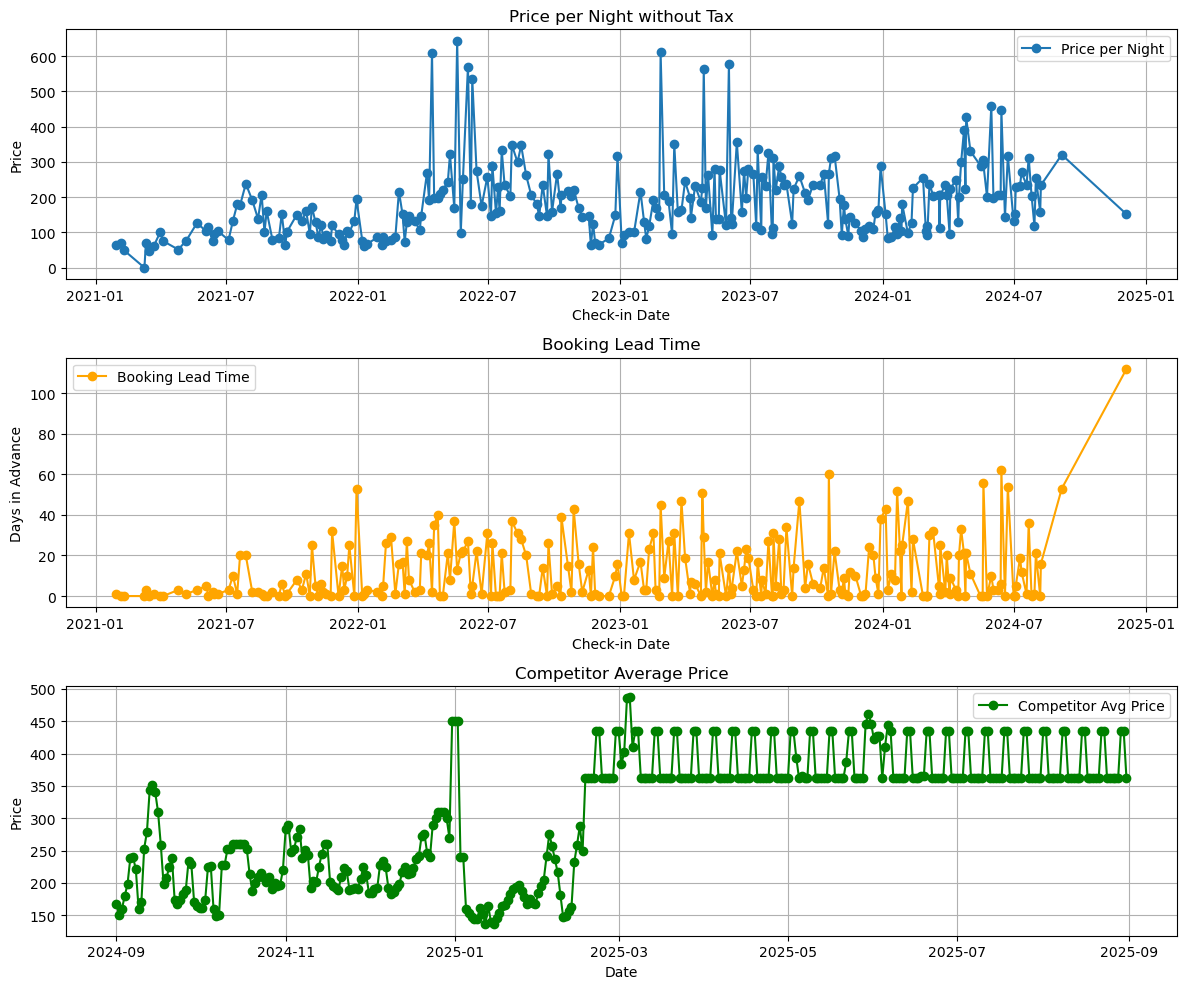

In [463]:
# Plot the time series data
import matplotlib.pyplot as plt

# Convwert the date columns to datetime
booking_data['Check-in date'] = pd.to_datetime(booking_data['Check-in date'])
competitor_data['Date'] = pd.to_datetime(competitor_data['Date'])

# Sort the data by date
booking_data = booking_data.sort_values(by='Check-in date')
competitor_data = competitor_data.sort_values(by='Date')

# Plot the time series data
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Plot the price per night without tax
axes[0].plot(booking_data['Check-in date'], booking_data['Price per night without tax'], marker='o', linestyle='-', label='Price per Night')
axes[0].set_title('Price per Night without Tax')
axes[0].set_xlabel('Check-in Date')
axes[0].set_ylabel('Price')
axes[0].grid(True)
axes[0].legend()

# Plot the booking lead time
axes[1].plot(booking_data['Check-in date'], booking_data['Booking window'], marker='o', linestyle='-', color='orange', label='Booking Lead Time')
axes[1].set_title('Booking Lead Time')
axes[1].set_xlabel('Check-in Date')
axes[1].set_ylabel('Days in Advance')
axes[1].grid(True)
axes[1].legend()

# Plot the competitor average price
axes[2].plot(competitor_data['Date'], competitor_data['Competitor Avg'], marker='o', linestyle='-', color='green', label='Competitor Avg Price')
axes[2].set_title('Competitor Average Price')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Price')
axes[2].grid(True)
axes[2].legend()


plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

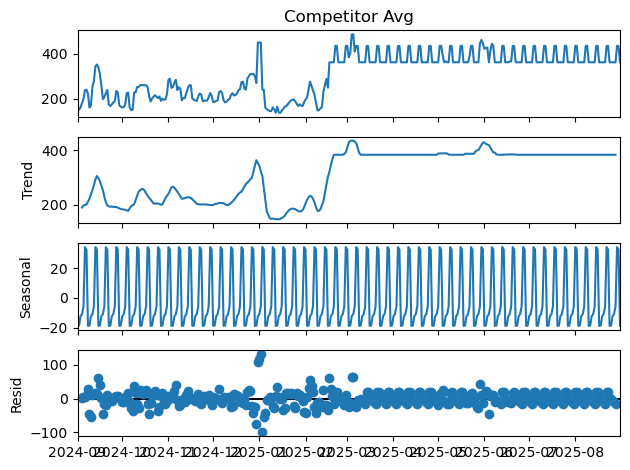

In [464]:
# Inpute missing values in the competitor data

# Check Date is in the correct format
competitor_data['Date'] = pd.to_datetime(competitor_data['Date'])

# Make Date as the index for the competitor data
competitor_data.set_index('Date', inplace=True)

# Decompose the time series data
decomposition = sm.tsa.seasonal_decompose(competitor_data['Competitor Avg'], model='additive', period=7)

# Extract the trend and seasonal components
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()

# Plot the trend and seasonal components
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

# Create a mask to only include dates before September 2024
mask = competitor_data.index < '2024-09-01'

# Apply the mask to impute values only for the missing data before September 2024
competitor_data['Imputed Competitor Avg'] = competitor_data['Competitor Avg']  # Start with the actual values
competitor_data.loc[mask, 'Imputed Competitor Avg'] = trend + seasonal  # Impute only for the masked period



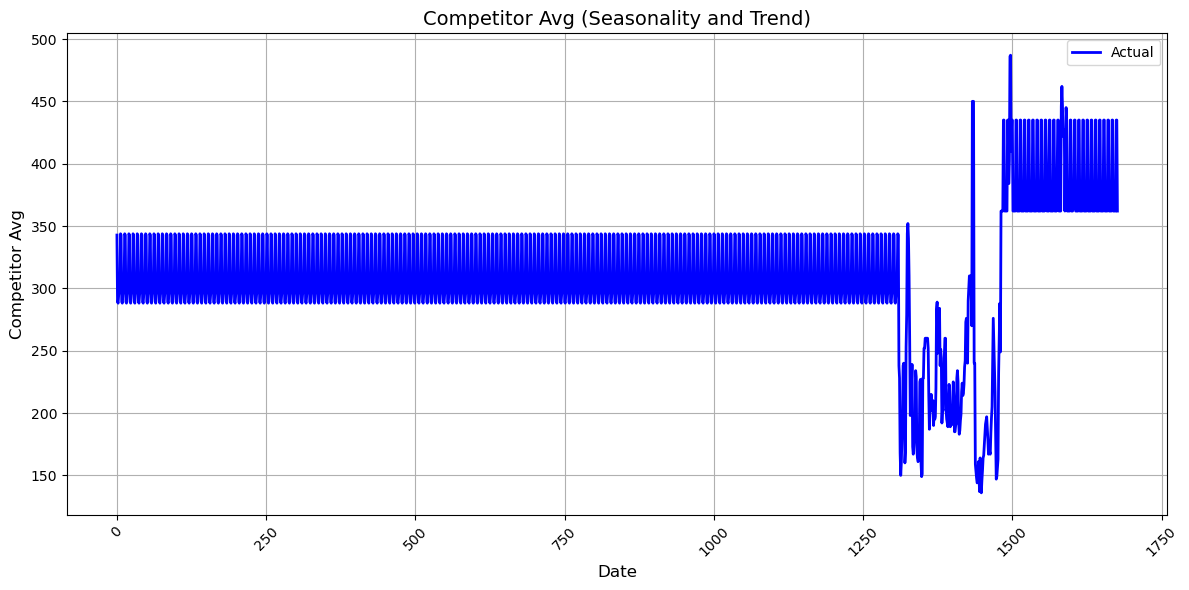

In [465]:
# Calculate the average price by day of the week for the competitor data
competitor_data['Day'] = competitor_data.index.day_of_week
competitor_avg = competitor_data.groupby('Day')['Imputed Competitor Avg'].mean().reset_index()

# Generate the missing date for the competitor data, previous to september 2024
competitor_avg_dict = competitor_avg.set_index("Day")["Imputed Competitor Avg"].to_dict()
start_date = booking_data['Check-in date'].min()
end_date = "2024-08-31"
missing_dates = pd.date_range(start=start_date, end=end_date, freq='D')
missing_days = missing_dates.day_of_week
missing_avg = missing_days.map(competitor_avg_dict)

# Create a dataframe with the missing dates and average price
missing_data = pd.DataFrame({'Date': missing_dates, 'Day': missing_days, 'Competitor Avg': missing_avg})

# Add the 2 dates that I lost in the previous step because of the range of dates in missing_dates
new_data = pd.DataFrame([{'Date': '2024-09-06', 'Day': 4, 'Competitor Avg': 238},
                         {'Date': '2024-12-05', 'Day': 3, 'Competitor Avg': 228}])

new_data['Date'] = pd.to_datetime(new_data['Date'])

missing_data = pd.concat([missing_data, new_data]).sort_values(by="Date").reset_index(drop=True)

# Concatenate the missing data with the competitor data
competitor_data = pd.concat([missing_data, competitor_data]).sort_values(by="Date").reset_index(drop=True)
# Formatting
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(competitor_data.index, competitor_data['Competitor Avg'], label='Actual', color='blue', linewidth=2)
plt.title("Competitor Avg (Seasonality and Trend)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Competitor Avg", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()  
plt.show()

In [466]:
booking_data['Check-in date'] = pd.to_datetime(booking_data['Check-in date'])
competitor_data['Date'] = pd.to_datetime(competitor_data['Date'])
booking_data = booking_data.sort_values(by='Check-in date').reset_index(drop=True)

# Merge the booking data with the competitor data
merged_data = pd.merge(booking_data, 
                       competitor_data[['Date', 'Competitor Avg']], 
                       left_on='Check-in date', 
                       right_on='Date', 
                       how='left')

merged_data.drop('Date', axis=1, inplace=True)

print(merged_data.head())
print(merged_data.tail())

# Check for rows that still hace missing price or Booking lead time
print(merged_data.isnull().sum())    

# print the rows with missing values
print(merged_data[merged_data['Competitor Avg'].isnull()])

# Check the shape of the data
print(merged_data.shape)

  Booking number Booking Date     Status Check-in date Check-out date  nights  \
0        TEST265   2021-01-29  Confirmed    2021-01-30     2021-02-02     3.0   
1        TEST264   2021-02-06  Confirmed    2021-02-06     2021-02-08     2.0   
2        TEST263   2021-02-09  Confirmed    2021-02-09     2021-03-09    28.0   
3        TEST261   2021-03-10  Confirmed    2021-03-10     2021-03-12     2.0   
4        TEST262   2021-03-09  Confirmed    2021-03-12     2021-03-15     3.0   

   Price per night without tax  Rent with VAT on top  Rent without VAT  \
0                        64.92                194.75            194.75   
1                        71.50                143.00            143.00   
2                        50.38               1410.50           1410.50   
3                         0.00                  0.00              0.00   
4                        71.00                213.00            213.00   

   Extras with VAT on top  ...  Portal / Agent   Website of origin  

In [467]:
# Build a simple linear regression model using the Booking window and Competitor Avg as features

# Split the data into training and testing sets
X = merged_data[['Booking window', 'Competitor Avg']]
y = merged_data['Price per night without tax']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the prices
y_pred = model.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

RMSE: 84.65749894751777
MAE: 63.97317935975397
R2 Score: 0.29913828782387175


In [468]:
# Build a more complex model

# Select the features and target variable
X = merged_data[['Booking window', 'Competitor Avg', 'Check-in date', 'Season', 'Website of origin', 'Weekend', 'Check-in Month']]
y = merged_data['Price per night without tax']

# Codify the Season column
if merged_data['Season'].dtype == 'object':
    X = pd.get_dummies(X, columns=['Season'], drop_first=True)
if merged_data['Check-in date'].dtype == 'datetime64[ns]':
    X['Check-in date'] = X['Check-in date'].dt.dayofweek
if merged_data['Website of origin'].dtype == 'object':
    X = pd.get_dummies(X, columns=['Website of origin'], drop_first=True)

expected_columns = X.columns

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the prices
y_pred = model.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")


RMSE: 80.88062061629228
MAE: 59.380492842548655
R2 Score: 0.3602792796657245


In [469]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

RMSE: 87.40905798119203
MAE: 64.07618911949687
R2 Score: 0.2528387377274961


In [470]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [471]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

RMSE: 93.70592393452839
MAE: 66.08413117606686
R2 Score: 0.14131166776700466


### **Conclusion**
In this analysis, we developed a predictive model to recommend nightly prices for the next 12 months based on historical booking data and competitor pricing. We tested three different models: Linear Regression, Random Forest Regressor, and XGBoost Regressor.

* Linear Regression performed the best, achieving an R² score of 0.36, RMSE of 80.88, and MAE of 59.38.
* Random Forest Regressor had similar performance, with an R² score of 0.25 and an RMSE of 87.4, but slightly higher MAE (64.07).
* XGBoost Regressor performed the worst, with an R² score of only 0.14 and the highest RMSE (93.7), indicating it was not well-suited for this dataset.

While Linear Regression provided the most stable results, further refinement and feature engineering are necessary to improve predictive accuracy and better capture pricing trends.

In [472]:
# Predict the price for 12 months in the future in the pricing data

from datetime import datetime, timedelta

future_dates = pd.date_range(start=datetime.today(), periods=12, freq='ME') 

future_data = pd.DataFrame({'Check-in date': future_dates})

missing_cols = set(expected_columns) - set(future_data.columns)
for col in missing_cols:
    future_data[col] = 0 

future_data = future_data[expected_columns]

future_data['Check-in Month'] = future_data['Check-in date'].dt.month
future_data['Weekend'] = future_data['Check-in date'].dt.weekday.isin([5, 6]).astype(int)  # sábado a domingo = 1
future_data['Booking window'] = 30 
future_data['Competitor Avg'] = merged_data['Competitor Avg'].median()  


def assign_season(month):
    if month in [1, 2, 3]: return 'Low'
    elif month in [8, 9, 10]: return 'Medium'
    else: return 'High'
future_data['Season'] = future_data['Check-in Month'].apply(assign_season)

future_data['Website of origin'] = 'www.airbnb.com'  

future_data['Check-in date'] = future_data['Check-in date'].dt.dayofweek

future_data = future_data.reindex(columns=expected_columns, fill_value=0)

future_data_scaled = scaler.transform(future_data)

future_predictions = model.predict(future_data_scaled)

future_data['Predicted Price'] = future_predictions
print(future_data[['Check-in date', 'Check-in Month', 'Predicted Price']])


    Check-in date  Check-in Month  Predicted Price
0               4               1       171.977325
1               4               2       186.528122
2               0               3       222.023254
3               2               4       358.519226
4               5               5       228.069885
5               0               6       327.015320
6               3               7       331.043762
7               6               8       262.915314
8               1               9       342.042358
9               4              10       244.407486
10              6              11       164.128677
11              2              12       160.666672
